In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [2]:
# 导入数据
f = open(r'stock_data1.csv')  
# 读入股票数据
df = pd.read_csv(f)     
# 获取最高价序列
data = np.array(df['high'])   
# 转成行序列
data = data[::-1]     

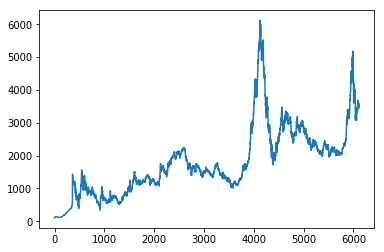

In [3]:
# 可视化数据
plt.plot(data)
# 标准化
normalize_data = (data-np.mean(data))/np.std(data)

In [4]:
# 增加维度
normalize_data = normalize_data[:,np.newaxis]       

In [5]:
# 设置参数
time_step = 20      #时间步
rnn_unit = 10       #hidden layer units
batch_size = 60     #每一批次训练多少个样例
input_size = 1      #输入层维度
output_size = 1     #输出层维度
lr = 0.001         #学习率

# 生成训练集
train_x,train_y = [],[]  
for i in range(len(normalize_data)-time_step-1):
    x = normalize_data[i:i+time_step]
    y = normalize_data[i+1:i+time_step+1]
    train_x.append(x.tolist())
    train_y.append(y.tolist()) 

In [6]:
# 定义输入占位符

X = tf.placeholder(tf.float32, [None,time_step,input_size])   
Y = tf.placeholder(tf.float32, [None,time_step,output_size])   

# 定义变量：输入层、输出层权重、偏置

weights = {
         'in': tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out': tf.Variable(tf.random_normal([rnn_unit,1]))
         }
biases = {
        'in': tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out' :tf.Variable(tf.constant(0.1,shape=[1,]))
        }

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# 定义LSTM模型

def lstm(batch):      
    
    w_in = weights['in']
    b_in = biases['in']
    # 将x转成2维作为隐藏层的输入
    input = tf.reshape(X,[-1,input_size]) 
    input_rnn = tf.matmul(input,w_in) + b_in
    
    # 将input_rnn转成3维作为lstm cell的输入
    input_rnn = tf.reshape(input_rnn,[-1,time_step,rnn_unit])  
    cell = tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    init_state = cell.zero_state(batch,dtype=tf.float32)
    
    # output_rnn是记录lstm每个输出节点的结果，final_states是最后一个cell的结果
    output_rnn,final_states = tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)  
    
    # 输出层的输入
    output = tf.reshape(output_rnn,[-1,rnn_unit]) 
    w_out = weights['out']
    b_out = biases['out']
    pred = tf.matmul(output,w_out) + b_out
    return pred,final_states

In [8]:
# 训练模型

def train_lstm():
    
    global batch_size
    pred,_ = lstm(batch_size)
    
    # 损失函数
    loss = tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    train_op = tf.train.AdamOptimizer(lr).minimize(loss)
    saver = tf.train.Saver(tf.global_variables())
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # 重复训练1000次
        for step in range(1000):
            start = 0
            end = start + batch_size
            tol_loss = 0
            while end<len(train_x):
                _,loss_ = sess.run([train_op,loss],feed_dict={X:train_x[start:end],Y:train_y[start:end]})
                start += batch_size
                end = start + batch_size
                tol_loss += loss_
            
            print(step,tol_loss)                 
        print("保存模型：",saver.save(sess,'model/stock.model'))


with tf.variable_scope('train1'):  
    train_lstm() 

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
0 199.0769814569503
1 258.67243717680685
2 129.9092101911083
3 115.70225350069813
4 15.285599182592705
保存模型： model/stock.model


INFO:tensorflow:Restoring parameters from model/stock.model
6111
6060


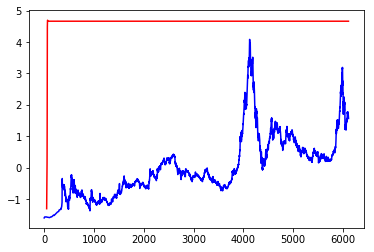

In [32]:
# 预测方式一：full sequence prediction
# 只用第一个timestep的序列，然后预测后面的时候使用先前的预测结果。
def prediction():
    # 预测时只输入[1,time_step,input_size]的测试数据
    pred,_ = lstm(1)      
    saver= tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        # 参数恢复
        saver.restore(sess, "model/stock.model") 

        # 取训练集最后一行为测试样本。shape=[1,time_step,input_size]
        prev_seq = train_x[0]
        predict = []
        # 得到之后的预测结果
        for i in range(time_step, len(normalize_data)-time_step):
            next_seq = sess.run(pred,feed_dict={X:[prev_seq]}).reshape(-1)
            predict.append(next_seq[-1])
            # 每次得到最后一个时间步的预测结果，与之前的数据加在一起，形成新的测试样本
            prev_seq = np.vstack((prev_seq[1:],next_seq[-1]))
        
        # 可视化结果
        plt.plot(list(range(len(normalize_data))), normalize_data, color='b')
        plt.plot(list(range(time_step,time_step+ len(predict))), predict, color='r')
        plt.show()

with tf.variable_scope('train1',reuse=True):  
    prediction()  

INFO:tensorflow:Restoring parameters from model/stock.model


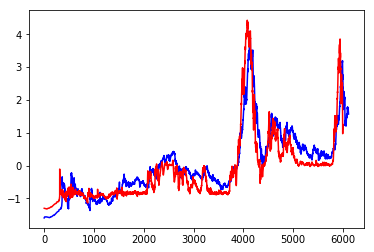

In [29]:
# 预测方式二：point-by-point prediction
# 预测的时候使用训练数据而非先前的预测结果
def prediction():
    pred,_ = lstm(batch_size)      
    saver= tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        # 参数恢复
        saver.restore(sess, "model/stock.model") 
        start = 0
        end = start + batch_size
        predict = []
        while end<len(train_x):
            next_seq = sess.run(pred,feed_dict={X:train_x[start:end]}).reshape(batch_size, -1)
            predict.extend(next_seq[:,-1])
            start += batch_size
            end = start + batch_size
        # 可视化结果
        plt.plot(list(range(len(normalize_data))), normalize_data, color='b')
        plt.plot(list(range(1, 1+ len(predict))), predict, color='r')
        plt.show()

with tf.variable_scope('train1',reuse=True):  
    prediction()  

In [9]:
# 参考
# https://lilianweng.github.io/lil-log/2017/07/08/predict-stock-prices-using-RNN-part-1.html